# Fine-tuning recognizer with keras-ocr

This is an interactive example of the code documented in https://keras-ocr.readthedocs.io/en/latest/examples/fine_tuning_recognizer.html

This example shows how to fine-tune the recognizer using an existing dataset. In this case,
we will use the "Born Digital" dataset from https://rrc.cvc.uab.es/?ch=1&com=downloads

First, we download our dataset. Below we get both the training and test datasets, but
we only use the training dataset. The training dataset consists of a single folder
containing images, each of which has a single word in it. The labels are in a text
file called `gt.txt`.

In [1]:
import random
import string
import math
import itertools
import os

import numpy as np
import imgaug
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection
import pandas as pd
import re

import keras_ocr

# assert tf.config.is_gpu_available()

# train_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(
#     split='train',
#     cache_dir='.'
# )
# test_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(
#     split='test',
#     cache_dir='.'
# )
# train_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]
# test_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]

In [47]:
# input_folder = 'data_plat_split'

# # column names: 'Vehicleregistrationplate', 'NameofFile'
# train_labels = pd.read_csv(os.path.join(input_folder, 'train.csv'))
# test_labels = pd.read_csv(os.path.join(input_folder, 'test.csv'))

# train_labels = [("./" + input_folder + "/train/" + row["NameofFile"], None, row['Vehicleregistrationplate'].lower()) for _, row in train_labels.iterrows()]
# test_labels = [("./" + input_folder + "/test/" + row["NameofFile"], None, row['Vehicleregistrationplate'].lower()) for _, row in test_labels.iterrows()]

In [51]:
input_folder = "raw_data_2/train/"

df = pd.read_csv(os.path.join(input_folder, 'DataTrain.csv'), sep=';')
df.drop(columns=['Unnamed: 0'], inplace=True)

train_labels = [("./" + input_folder + row["NameofFile"], None, row['Vehicleregistrationplate'].lower()) for _, row in df.iterrows()]

We next build our recognizer, using the default options to get a pretrained model.

In [52]:
recognizer = keras_ocr.recognition.Recognizer()
recognizer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

Looking for C:\Users\vitos\.keras-ocr\crnn_kurapan.h5


We need to convert our dataset into the format that :code:`keras-ocr` requires. To
do that, we have the following, which includes support for an augmenter to
generate synthetically altered samples. Note that this code is set up to skip
any characters that are not in the recognizer alphabet and that all labels
are first converted to lowercase.


In [53]:
batch_size = 8
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 1.0)),
    imgaug.augmenters.AdditiveGaussianNoise(scale=0.01*255),
    imgaug.augmenters.GaussianBlur(sigma=(0.0, 1.0))
], random_order=True)

train_labels, validation_labels = sklearn.model_selection.train_test_split(train_labels, test_size=0.1, random_state=42)
(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

As a sanity check, we show one of the samples.

text: b1mam


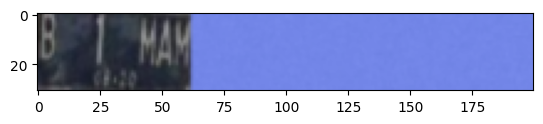

In [54]:
image, text = next(training_image_gen)
print('text:', text)
_ = plt.imshow(image)


Now we can run training.

In [57]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('recognizer_license.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('license_plate.csv')
]
recognizer.training_model.fit_generator(
    generator=training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=20,
)

Epoch 1/20


C:\Users\vitos\AppData\Local\Temp\ipykernel_35276\3068635815.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  recognizer.training_model.fit_generator(


90/90 [==============================] - 21s 157ms/step - loss: 16.7530 - val_loss: 12.9708
Epoch 2/20
90/90 [==============================] - 12s 137ms/step - loss: 8.9892 - val_loss: 7.4840
Epoch 3/20
90/90 [==============================] - 12s 137ms/step - loss: 6.6137 - val_loss: 7.1024
Epoch 4/20
90/90 [==============================] - 12s 136ms/step - loss: 5.0607 - val_loss: 5.2431
Epoch 5/20
90/90 [==============================] - 12s 134ms/step - loss: 4.2275 - val_loss: 6.1639
Epoch 6/20
90/90 [==============================] - 12s 136ms/step - loss: 3.3182 - val_loss: 5.4746
Epoch 7/20
90/90 [==============================] - 12s 137ms/step - loss: 2.8104 - val_loss: 4.5629
Epoch 8/20
90/90 [==============================] - 12s 135ms/step - loss: 2.3683 - val_loss: 5.7640
Epoch 9/20
90/90 [==============================] - 12s 136ms/step - loss: 2.0342 - val_loss: 4.8884
Epoch 10/20
90/90 [==============================] - 12s 135ms/step - loss: 1.7513 - val_loss: 4.857

Finally, run inference on a test sample.

1/1 [==============================] - 0s 131ms/step
Predicted: b1450un, Actual: b1451un


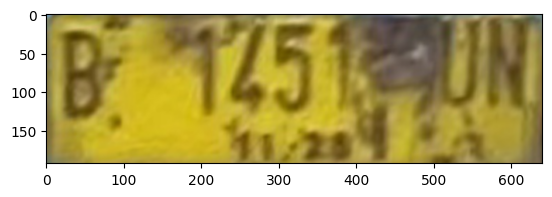

In [67]:
image_filepath, _, actual = validation_labels[70]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

In [75]:
df = pd.read_csv("DataTest.csv", sep=';')
# df.drop(columns=['Unnamed: 0'], inplace=True)

In [80]:
recognized = []
for i, row in df.iterrows():
    filename = row['Name of File']
    image_filepath = "./raw_data_2/test/" + filename
    predicted = recognizer.recognize(image_filepath)
    recognized.append(predicted)

1/1 [==============================] - 0s 64ms/step


In [84]:
df["Predicted"] = recognized
df["Predicted"] = df["Predicted"].str.upper()

In [86]:
df.to_excel("submission.xlsx", index=False)

In [73]:
train_labels[98]

('./raw_data_2/train/DataTrain621.png', None, 'b1020scz')

In [86]:
df.to_excel("submission.xlsx", index=False)

## Loaded Model

In [6]:
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789"
recognizer = keras_ocr.recognition.Recognizer()
recognizer.model.load_weights('recognizer_license.h5')

Looking for C:\Users\vitos\.keras-ocr\crnn_kurapan.h5


In [10]:
recognizer.recognize("raw_data_2/test/DataTest75.png")


1/1 [==============================] - 0s 134ms/step


'b1075da'

In [11]:
df = pd.read_excel("submission.xlsx")

In [12]:
df

,Name of File,Unnamed: 1,Label,Predicted
0,DataTest1.png,NaN,AD7034OE,AD70340E
1,DataTest2.png,NaN,A9388EX,A9388EX
2,DataTest3.png,NaN,B16TB,B16TB
3,DataTest4.png,NaN,B1661TKZ,B1661TKZ
4,DataTest5.png,NaN,AD3772ABE,AD572DO
...,...,...,...,...
95,DataTest96.png,NaN,B1285OL,B1285L
96,DataTest97.png,NaN,AB8644PK,AB864PK
97,DataTest98.png,NaN,AG9718EG,AG9718EG
98,DataTest99.png,NaN,B1509UN,B1509UN
